In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from os import path, listdir

from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class VehiclesDataset(Dataset):
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.images = listdir(path.join(dataset_dir, 'reconstructed'))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        reconstructed = read_image(
            path.join(self.dataset_dir, 'reconstructed', self.images[idx]),
            ImageReadMode.RGB
        ) / 255.0
        original = read_image(
            path.join(self.dataset_dir, 'original', self.images[idx]),
            ImageReadMode.RGB
        ) / 255.0
        points = read_image(
            path.join(self.dataset_dir, 'points', self.images[idx]),
            ImageReadMode.GRAY
        )

        return reconstructed, original, points

In [3]:
from torch import nn
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

class Detailer(nn.Module):
    def __init__(self, encoder_params, decoder_params, output_params, loss='l1'):
        super().__init__()

        self.encoder = nn.ModuleList()
        for i, (out_channels, kernel_size, pool) in enumerate(encoder_params):
            in_channels = 4 if i == 0 else encoder_params[i - 1][0]

            self.encoder.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.MaxPool2d(pool),
            ))

        self.decoder = nn.ModuleList()
        for i, (out_channels, kernel_size, scale) in enumerate(decoder_params):
            in_channels = encoder_params[-1][0] if i == 0 else decoder_params[i - 1][0]

            self.decoder.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
                nn.Upsample(scale_factor=scale),
            ))
        
        self.output = nn.Sequential(
            nn.Conv2d(decoder_params[-1][0] + 4, *output_params, padding='same'),
            nn.Sigmoid()
        )

        if loss not in {'l1', 'l2', 'bce', 'ssim', 'lpips'}:
            raise ValueError('Loss needs to be one of ["l1", "l2", "bce", "ssim", "lpips"]')
        
        self._loss = loss
        
        if loss == 'l1':
            self.loss_function = nn.L1Loss()
        elif loss == 'l2':
            self.loss_function = nn.MSELoss()
        elif loss == 'bce':
            self.loss_function = nn.BCELoss()
        elif loss == 'ssim':
            self.loss_function = StructuralSimilarityIndexMeasure().to(device)
        elif loss == 'lpips':
            self.loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

    def forward(self, x):
        x_in = x

        for layer in self.encoder:
            x = layer(x)

        for layer in self.decoder:
            x = layer(x)
        
        x = torch.concat([x_in, x], dim=1)
        
        return self.output(x)
    
    def loss(self, outputs, targets):
        alpha = 0.2
        l = self.loss_function(outputs, targets)

        if self._loss == 'ssim':
            l = 1 - l
        
        if self._loss == 'lpips':
            self.loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)
        
        return l

In [37]:
from torchinfo import summary

model = Detailer(
    encoder_params=[(64, 5, 2), (128, 5, 2)],
    decoder_params=[(128, 5, 2), (64, 5, 2)],
    output_params=(3, 5),
    loss='l1'
).to(device)

batch_size = 64
summary(model, (batch_size, 4, 256, 256), device=torch.device(device))

Layer (type:depth-idx)                   Output Shape              Param #
Detailer                                 [64, 3, 256, 256]         --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [64, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [64, 64, 256, 256]        6,464
│    │    └─ReLU: 3-2                    [64, 64, 256, 256]        --
│    │    └─BatchNorm2d: 3-3             [64, 64, 256, 256]        128
│    │    └─MaxPool2d: 3-4               [64, 64, 128, 128]        --
│    └─Sequential: 2-2                   [64, 128, 64, 64]         --
│    │    └─Conv2d: 3-5                  [64, 128, 128, 128]       204,928
│    │    └─ReLU: 3-6                    [64, 128, 128, 128]       --
│    │    └─BatchNorm2d: 3-7             [64, 128, 128, 128]       256
│    │    └─MaxPool2d: 3-8               [64, 128, 64, 64]         --
├─ModuleList: 1-2                        --                        --
│    

In [5]:
import sys

from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

dataset = VehiclesDataset(path.join('..', '..', 'dataset'))
dataset_train, dataset_val, dataset_test = random_split(
    dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(1)
)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.001)

Calculate loss for reconstructed images

In [6]:
model.eval()
with torch.no_grad():
    for type, dataloader in [('train', dataloader_train), ('val', dataloader_val)]:
        l = 0.0
        for i, (reconstructed, original, _) in enumerate(dataloader):
            reconstructed, original  = reconstructed.to(device), original.to(device)
            loss = model.loss(reconstructed, original)

            l += loss

            reconstructed.detach()
            original.detach()
        
        print(f'{type}_loss: {l / (i + 1):.5f}')

train_loss: 0.06580
val_loss: 0.06574


In [7]:
epoch = -1
best_loss, best_model = float('inf'), None
hist = {
    'train_loss': [],
    'val_loss': [],
}

Train loop

In [ ]:
from copy import deepcopy

epochs = 50

for epoch in range(epoch + 1, epoch + 1 + epochs):
    pbar = tqdm(total=(len(dataloader_train) + len(dataloader_val)))

    train_loss = 0.0
    model.train()
    for i, (reconstructed, original, points) in enumerate(dataloader_train):
        original = original.to(device)
        input = torch.concat([reconstructed, points], dim=1).to(device)

        optimizer.zero_grad()
        outputs = model(input)
        loss = model.loss(outputs, original)
        loss.backward()
        optimizer.step()

        train_loss += loss

        pbar.set_description(
            f'Epoch {epoch + 1:3} - '
            f'train_loss {train_loss / (i + 1):5f}'
        )
        pbar.update(1)
        sys.stderr.flush()   

        input.detach()
        original.detach()
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, (reconstructed, original, points) in enumerate(dataloader_val):
            original = original.to(device)
            input = torch.concat([reconstructed, points], dim=1).to(device)

            outputs = model(input)
            loss = model.loss(outputs, original)

            val_loss += loss

            pbar.set_description(
                f'Epoch {epoch + 1:3} - '
                f'train_loss {train_loss / (i + 1):5f} - '
                f'val_loss {val_loss / (j + 1):5f}'
            )
            pbar.update(1)
            sys.stderr.flush()   

            input.detach()
            original.detach()

    train_loss /= i + 1
    val_loss /= j + 1
    
    # Save the model with the best validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())

    hist['train_loss'].append(train_loss.detach().cpu().item())
    hist['val_loss'].append(val_loss.detach().cpu().item())

    pbar.close()

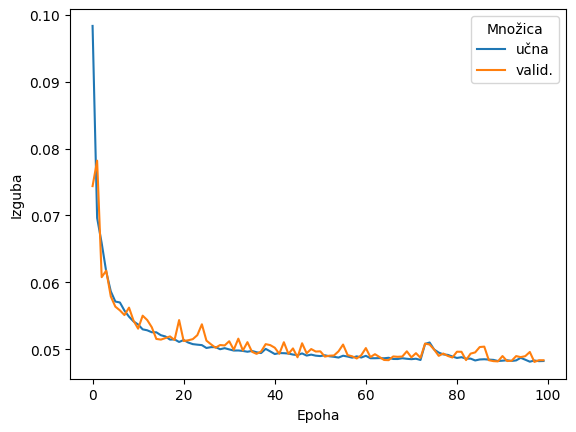

In [9]:
plt.plot(hist['train_loss'], label='učna')
plt.plot(hist['val_loss'], label='valid.')
plt.legend(title='Množica')
plt.xlabel('Epoha')
plt.ylabel('Izguba')
plt.show()

Load best model weights (and save it or load load it from file)

In [8]:
print(f'Best loss: {best_loss:.5f}')
model.load_state_dict(best_model)
# torch.save(model.state_dict(), path.join('models', 'model.pt'))

Best loss: 0.22141


In [16]:
# with open('model_hist.csv', 'wt') as f:
#     f.write('train_loss,val_loss\n')
#     for t, v in zip(hist['train_loss'], hist['val_loss']):
#         f.write(f'{t},{v}\n')

In [38]:
model.load_state_dict(torch.load(path.join('models', 'model.pt')))

<All keys matched successfully>

Compare loss functions

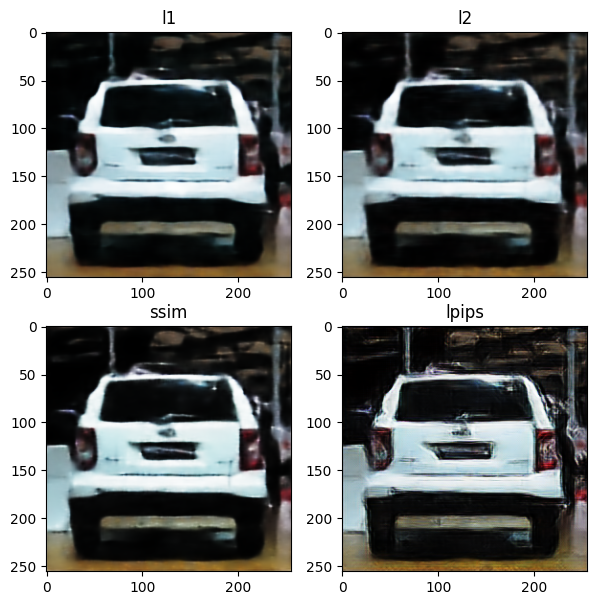

In [35]:
plt.figure(figsize=(7, 7))

for i, l in enumerate(['l1', 'l2', 'ssim', 'lpips']):
    model = Detailer(
        encoder_params=[(64, 5, 2), (128, 5, 2)],
        decoder_params=[(128, 5, 2), (64, 5, 2)],
        output_params=(3, 5),
        loss=l
    ).to(device)

    model.load_state_dict(torch.load(path.join('models', f'model_{l}.pt')))

    model.eval()
    # 26, 69
    reconstructed, original, points = dataset_test[26]
    
    reconstructed = reconstructed[None, :].to(device)
    input = torch.concat([reconstructed, points[None, :].to(device)], dim=1).to(device)
    original = original[None, :].to(device)
    output = model(input)

    plt.subplot(2, 2, i + 1)
    plt.title(l)
    plt.imshow(output.cpu().detach()[0].permute((1, 2, 0)))
    # plt.imsave(f'loss_{l}.png', output.cpu().detach()[0].permute((1, 2, 0)).numpy())

plt.show()

Single image evaluation

loss    |   rec   |   out   |
l1      | 0.08300 | 0.05689 |
l2      | 0.01765 | 0.01148 |
bce     | 0.56414 | 0.55045 |
ssim    | 0.50921 | 0.67874 |
lpips   | 0.62040 | 0.32521 |


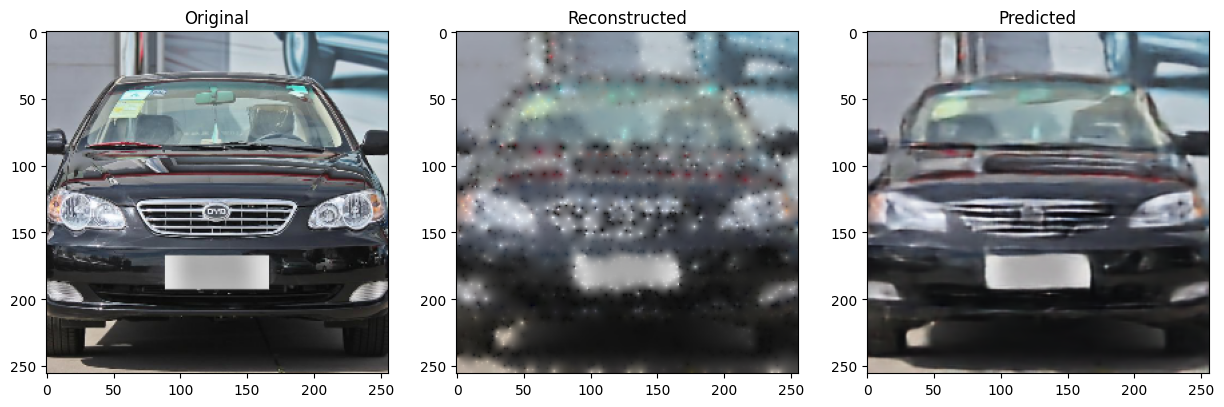

In [40]:
model.eval()

# used_images = [2002, 2009, 2017, 2080, 2110, 2155, 2190, 2216]

reconstructed, original, points = dataset_test[0]
# reconstructed, original, points = dataset_test[2030] # Worst
# reconstructed, original, points = dataset_test[1238] # Best

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(original.permute((1, 2, 0)))
plt.subplot(1, 3, 2)
plt.title('Reconstructed')
plt.imshow(reconstructed.permute((1, 2, 0)))

# plt.imsave('original.png', original.permute((1, 2, 0)).cpu().detach().numpy())
# plt.imsave('reconstructed.png', reconstructed.permute((1, 2, 0)).cpu().detach().numpy())

reconstructed = reconstructed[None, :].to(device)
input = torch.concat([reconstructed, points[None, :].to(device)], dim=1).to(device)
original = original[None, :].to(device)
output = model(input)

print(f'{"loss":7} | {"rec":^7} | {"out":^7} |')
for loss in ['l1', 'l2', 'bce', 'ssim', 'lpips']:
    print(f'{loss:7}', end=' |')
    for image in [reconstructed, output]:
        if loss == 'l1':
            loss_function = nn.L1Loss()
        elif loss == 'l2':
            loss_function = nn.MSELoss()
        elif loss == 'bce':
            loss_function = nn.BCELoss()
        elif loss == 'ssim':
            loss_function = StructuralSimilarityIndexMeasure().to(device)
        elif loss == 'lpips':
            loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)

        print(f'{loss_function(image, original):8.5f}', end=' |')
    print()

plt.subplot(1, 3, 3)
plt.title('Predicted')
plt.imshow(output.cpu().detach()[0].permute((1, 2, 0)))
# plt.imsave('predicted.png', output.cpu().detach()[0].permute((1, 2, 0)).numpy())
plt.show()

Test set evaluation

In [9]:
test_losses_start = dict.fromkeys(['l1', 'l2', 'bce', 'ssim', 'lpips'], 0)
test_losses = dict.fromkeys(['l1', 'l2', 'bce', 'ssim', 'lpips'], 0)

model.eval()
with torch.no_grad():
    for j, (reconstructed, original, points) in enumerate(dataloader_test):
        original = original.to(device)
        input = torch.concat([reconstructed, points], dim=1).to(device)

        outputs = model(input)

        for loss in ['l1', 'l2', 'bce', 'ssim', 'lpips']:
            if loss == 'l1':
                loss_function = nn.L1Loss()
            elif loss == 'l2':
                loss_function = nn.MSELoss()
            elif loss == 'bce':
                loss_function = nn.BCELoss()
            elif loss == 'ssim':
                loss_function = StructuralSimilarityIndexMeasure().to(device)
            elif loss == 'lpips':
                loss_function = LearnedPerceptualImagePatchSimilarity(normalize=True).to(device)
        
            test_losses_start[loss] += loss_function(reconstructed.to(device), original)
            test_losses[loss] += loss_function(outputs, original)

        input.detach()
        original.detach()
    
    test_losses_start = { k: v / (j + 1) for k, v in test_losses_start.items() }
    test_losses = { k: v / (j + 1) for k, v in test_losses.items() }

for k, v in test_losses.items():
    print(f'{k}: {test_losses_start[k]:.5f} -> {v.item():.5f}')

l1: 0.06570 -> 0.04786
l2: 0.01260 -> 0.00924
bce: 0.51091 -> 0.50215
ssim: 0.57544 -> 0.67887
lpips: 0.51434 -> 0.30823


Find best and worst model result

In [22]:
model.eval()

worst_index, worst_score = 0, float('+inf')
best_index, best_score = 0, float('-inf')

for i, (reconstructed, original, points) in tqdm(enumerate(dataset_test)):
    reconstructed = reconstructed[None, :].to(device)
    input = torch.concat([reconstructed, points[None, :].to(device)], dim=1).to(device)
    original = original[None, :].to(device)
    output = model(input)

    loss_function = nn.L1Loss()
    loss_before = loss_function(reconstructed.to(device), original)
    loss_after = loss_function(output, original)
    score = ((loss_before - loss_after) / loss_before).detach().cpu().item()

    if score < worst_score:
        worst_index, worst_score = i, score
    elif score > best_score:
        best_index, best_score = i, score

    input.detach()
    original.detach()

print(worst_index, worst_score)
print(best_index, best_score)

2734it [00:19, 142.39it/s]

2030 0.04828185960650444
1238 0.5480116009712219
